<a href="https://colab.research.google.com/github/OldGoose/ORA-Project-Santa-2021---The-Merry-Movie-Montage/blob/main/Williams_Construction_7!_superpermutation_with_LKH_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Williams Construction 7! superpermutation with LKH.


In this notebook, we use 7! superpermutation which from Robin Houston to our initial data. The flowchart as below:
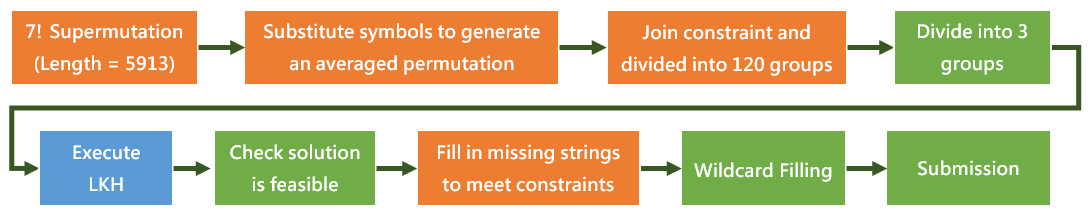
#### REFERENCES
https://www.kaggle.com/ks2019/santa-baseline-2481 <br />
https://www.kaggle.com/yosshi999/wildcard-postprocessing-using-dynamic-programming

### Import Package

In [1]:
import itertools
import random
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import datetime
from tqdm.notebook import tqdm
from sklearn.model_selection import StratifiedKFold
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/Santa2021') 

#!wget http://webhotel4.ruc.dk/~keld/research/LKH-3/LKH-3.0.7.tgz
!tar xvfz LKH-3.0.7.tgz
!cd LKH-3.0.7; make

Mounted at /content/drive
LKH-3.0.7/
LKH-3.0.7/pr2392.par
LKH-3.0.7/whizzkids96.atsp
LKH-3.0.7/Makefile
LKH-3.0.7/whizzkids96.par
LKH-3.0.7/pr2392.tsp
LKH-3.0.7/DOC/
LKH-3.0.7/README.txt
LKH-3.0.7/SRC/
LKH-3.0.7/SRC/Penalty_CVRPTW.c
LKH-3.0.7/SRC/RestoreTour.c
LKH-3.0.7/SRC/SolveKMeansSubproblems.c
LKH-3.0.7/SRC/IsCommonEdge.c
LKH-3.0.7/SRC/Penalty_TSPPD.c
LKH-3.0.7/SRC/ReadProblem.c
LKH-3.0.7/SRC/BestKOptMove.c
LKH-3.0.7/SRC/Distance_SPECIAL.c
LKH-3.0.7/SRC/Penalty_TSPDL.c
LKH-3.0.7/SRC/Penalty_PDPTW.c
LKH-3.0.7/SRC/Penalty_ACVRP.c
LKH-3.0.7/SRC/CreateCandidateSet.c
LKH-3.0.7/SRC/OBJ/
LKH-3.0.7/SRC/Forbidden.c
LKH-3.0.7/SRC/Penalty_CCVRP.c
LKH-3.0.7/SRC/Penalty_M_PDTSP.c
LKH-3.0.7/SRC/Best5OptMove.c
LKH-3.0.7/SRC/RecordBetterTour.c
LKH-3.0.7/SRC/Best4OptMove.c
LKH-3.0.7/SRC/Exclude.c
LKH-3.0.7/SRC/C.c
LKH-3.0.7/SRC/IsCandidate.c
LKH-3.0.7/SRC/Make3OptMove.c
LKH-3.0.7/SRC/Make2OptMove.c
LKH-3.0.7/SRC/ResetCandidateSet.c
LKH-3.0.7/SRC/LKHmain.c
LKH-3.0.7/SRC/SolveSFCSubproblems.c
LKH-3.

### 1. 7! Supermutation
We can get the superpermutation for n = 7 from Williams construction which length 5913.

In [2]:
## 進行7個字符的超排列組合生成 ##
Num = 3
permutation = "121"

#生成7!排列組合的總字串
for Num in range(3, 8):
    new_permutation = []
    for i in range(len(permutation) - Num + 2):
        substring = permutation[i:i + (Num - 1)]
        if all(str(x) in substring for x in range(1, Num)):
            new_permutation.append(substring + str(Num) + substring)
    permutation = new_permutation[:1]
    for i in range(len(new_permutation) - 1):
        m = new_permutation[i]
        n = new_permutation[i + 1]
        for j in range(1, len(m) + 1):
            if n[:j] == m[-1*j:]:
                break
        permutation.append(n[j:])
    permutation = "".join(permutation)
    print(Num, len(permutation)) #列出7!的排列組合總長度

3 9
4 33
5 153
6 873
7 5913


### 2. Substitute symbols to generate an averaged permutation.
We swap the characters 1 and 7, and 2 and 6, to make the permutation of three group have the same length.

In [3]:
print('Before swapping')
print('1', permutation.count('1'))
print('2', permutation.count('2'))
print('3', permutation.count('3'))
print('4', permutation.count('4'))
print('5', permutation.count('5'))
print('6', permutation.count('6'))
print('7', permutation.count('7'))
print()

#Swapping 1 and 7, 2 and 6.
permutation = permutation.replace('1','t')
permutation = permutation.replace('7','1')
permutation = permutation.replace('t','7')
permutation = permutation.replace('2','t')
permutation = permutation.replace('6','2')
permutation = permutation.replace('t','6')

print('After swapping')
print('1', permutation.count('1'))
print('2', permutation.count('2'))
print('3', permutation.count('3'))
print('4', permutation.count('4'))
print('5', permutation.count('5'))
print('6', permutation.count('6'))
print('7', permutation.count('7'))

Before swapping
1 874
2 873
3 872
4 870
5 864
6 840
7 720

After swapping
1 720
2 840
3 872
4 870
5 864
6 873
7 874


Fold the string  into 120 groups, the length of each circle is 53.

In [4]:
permutations = {}
sub_perms = {}
ord_permutations = []
s_flag = 0
data = []
for i in range(len(permutation) - 6): #共有5913 - 6 = 5907個長度為7的字符串
    perm = permutation[i:i + 7] #從5907個排列組合中逐一列出長度為7的字符串
    if ''.join((sorted(perm))) == '1234567': #當取出長度為7的字串中同時有1~7的數字時
        if s_flag == "Off":
            s_flag = i
            data = []
        data.append(perm)
        
        if perm.startswith('12'): #若字符串的開頭為'12'時
            e_flag = i + 7 #該字串的結束索引為i + 7 (也就是從字首往後推7個字符)
            
            permutations[perm] = permutation[s_flag:e_flag] #存放每53個字符串(放在下一個'12'開頭的key底下)
            sub_perms[perm] = data #存放每當'12'過後的所有的7個字符串
            ord_permutations.append(permutations[perm]) #存放每53個字符串(串列)
            s_flag = "Off"  #啟動flag="Off"重新歸零計算

### 3. Join constraint and divided into 120 groups.
Put the suffix to the beginning of the string and add "🎅🤶".
Swap 2 codes at the end of the suffix and add "🎅🤶"
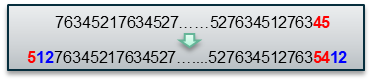

In [5]:
## 修改這120個分組，使每個輸出序列包含2組轉換字符 ##

substr_list = []
substr_cate = []
substr_group = []

for str_ in ord_permutations:
    substring = str_[-1] + '12' + str_[:-2] + str_[-1] + str_[-2] + '12'
    substr_list.append(substring)
    substr_cate.append(str_[-1] + str_[-2]) #取出原本每個字串的後2個字符(顛倒)
    substr_group.append(str_[:3]) #取出原本每個字串的前3個字符

substr_list = np.array(substr_list) #將字符串放到list
substr_cate = np.array(substr_cate) #將字符串後2個字符放到category
substr_group = np.array(substr_group) #將字符串前3個字符放到group

Pick keywords and use them as indexes for grouping

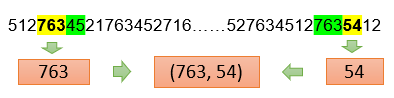

In [6]:
#觀察超排列規則，當字符串字尾末三碼與另一個字符串字首前三碼相同時，則此兩個字串可以前後合併
skf = StratifiedKFold(n_splits = 3)

#將字串拆為category及group兩種類別
df = pd.DataFrame([substr_group, substr_cate],index=['group','category']).T.sort_values(['group','category'])
df = df.reset_index(drop = True) #重新定義index序號

#每個相同的group都對應2組不同的category(每2組category互為倒數)
subset = df[df.category == df.category.apply(lambda x:''.join(sorted(x)))].reset_index(drop=True) #依照Group欄位數字大小(由小到大)依序排列

#unique函數去除其中重複的元素，並按元素由大到小返回一個新的無元素重複的清單
codings = {x:i for i,x in enumerate(subset.category.unique())} #針對subset.category濾除重複出現的值

#將codings內對應值的index 填入subset新增欄位subset['encoded']
subset['encoded'] = subset.category.apply(lambda x: codings[x]) 


### 4. Divide into 3 groups

In [7]:
#針對subset隨機將【encoded】欄位分成3個群
for split, (train, test) in enumerate(skf.split(subset, subset.encoded)):
    subset.loc[test,'split'] = split
   
#將subset內的'group','category'欄位及對應的分群編號取出放入到temp_splits dict中
temp_splits = subset.set_index(['group','category']).split.to_dict()

splits = {}
for group,category in temp_splits:
    splits[(group,category)] = int(temp_splits[(group,category)])
    category_rev = category[-1] + category[0] #將category欄位的資料反轉並放到參數category_rev
    splits[(group,category_rev)] = int((temp_splits[(group,category)]+1)%3) #%代表取餘數 (此時splits已增加至120組)

subset.split.value_counts() #計算分群後各群的總數

2.0    20
1.0    20
0.0    20
Name: split, dtype: int64

In [8]:
# 建立c2s_df串列，分別依照分群類別、末2碼類別，分別分層將對應的字符串放入c2s_df
splt_substr = [[],[],[]]
splt_cate = [[],[],[]]
c2s_df = [{},{},{}]

for i in range(120):
    str_ = substr_list[i] #分別從120個特殊字符串中逐一取出
    cat_ = substr_cate[i] #分別從各特殊字符串倒數第3、4碼的字符清單中逐一取出
    group = substr_group[i] #分別從各特殊字符串前3碼的字符清單中逐一取出
    ss = int(splits[group, cat_])
    splt_substr[ss].append(str_) #依照分群代碼，將所有的58碼字符串放入各群 (每群40組字符串)
    splt_cate[ss].append(cat_) #依照分群代碼，將所有的末3、4碼的字符串放入各群 (每群40組字符串)
    if cat_ not in c2s_df[ss]:
        c2s_df[ss][cat_] = []
    c2s_df[ss][cat_].append(str_)

### 5. Execute LKH

In [9]:
## 建立TSP演算法
def get_tsp_solution(DistMatrix, timer=30, verbose=0):
    
    # 建立distance矩陣
    SIZE = len(DistMatrix)
    D = DistMatrix.astype(int)
            
    # 將資料寫入檔案
    f = open(f'group.par','w')
    f.write("PROBLEM_FILE = ../distances.atsp\n")
    f.write("TOUR_FILE = ../output.txt\n")
    f.write(f"OPTIMUM = {SIZE}\n")
    f.write(f"BACKTRACKING = YES\n")
    f.write(f"MAX_CANDIDATES = 7 SYMMETRIC\n")
    f.write("MOVE_TYPE = 3\n")
    f.write("PATCHING_C = 3\n")
    f.write("PATCHING_A = 2\n")
    f.write("RUNS = 1\n")
    f.write(f"TIME_LIMIT = {timer}\n") #seconds
    f.close()
    
    # 將資料寫入變數
    f = open(f'distances.atsp','w')
    f.write("NAME: distances\n")
    f.write("TYPE: ATSP\n")
    f.write("COMMENT: Asymmetric TSP\n")
    f.write(f"DIMENSION: {SIZE}\n")
    f.write("EDGE_WEIGHT_TYPE: EXPLICIT\n")
    f.write("EDGE_WEIGHT_FORMAT: FULL_MATRIX\n")
    f.write("EDGE_WEIGHT_SECTION\n")
    for j in range(SIZE):
        #if j%25==0: print(j,', ',end='')
        for k in range(SIZE):
            f.write(f"{D[j,k]:2d} ") 
        f.write("\n")
    f.close()
    
    #執行TSP求解器
    if verbose==0:
        !cd LKH-3.0.7; ./LKH ../group.par >> out.txt
    else:
        !cd LKH-3.0.7; ./LKH ../group.par
    
    #生成演算結果
    with open('output.txt') as f:
        lines = f.readlines()
    for i,ln in enumerate(lines):
        if 'TOUR_SECTION' in ln: break
    perms = [int(x[:-1]) for x in lines[i+1:-2] ]
    
    return perms

In [10]:
starttime = datetime.datetime.now()
## 建立distance matrix，將category依照對應關係放入欄位
out_strs = []
out_list = [[],[],[]]

for spt in range(3):
    print("Solving for split", spt)
    strs = splt_substr[spt]
    cats = splt_cate[spt]
    #print('strs', splt_cate[spt])
    #print('cats', splt_cate[spt])
    # 建立distance matrix
    DistMatrix = np.ones((len(cats),len(cats)))
    for i, p in enumerate(cats):
        for j, q in enumerate(cats):
            if p[1] == q[0]:
                DistMatrix[i,j] = 0

    #以get_tsp_solution函數取得求解          
    solution = get_tsp_solution(DistMatrix,verbose=0)

    #將對應的字符串放入out_list
    output = ""
    for x in solution:
        out_list[spt].append(strs[x - 1])
        if len(output)==0:
            output += strs[x - 1]
        else:
            output += strs[x - 1][3:]
    print("length of solution", len(output))
    out_strs.append(output)

Solving for split 0
length of solution 2203
Solving for split 1
length of solution 2203
Solving for split 2
length of solution 2203


### 6. Check solution is feasible

In [11]:
## 確認排列組合結果是否為為有效組合
LETTERS = list(map(str,range(1,8)))
permutations = [''.join(x) for x in itertools.permutations(LETTERS)]
mandatory = [x for x in permutations if x.startswith('12')]
non_mandatory = [x for x in permutations if not x.startswith('12')]
print(len(permutations),len(mandatory),len(non_mandatory))

5040 120 4920


### 7. Fill in missing strings to meet constraints.

In [12]:
#將短缺的特殊字符串加入每群
for i in range(3):
    for x in mandatory:
        if x not in out_strs[i]:
            out_strs[i] = out_strs[i] + x
for i in range(3):
    print(len(out_strs[i]))

2483
2483
2483


In [13]:
for p in permutations:
    if p not in out_strs[0] and p not in out_strs[1] and p not in out_strs[2]:
        print(p)
              
for p in mandatory:
    if p not in out_strs[0] and p not in out_strs[1] and p not in out_strs[2]:
        print(p)
#No News is good news.

In [14]:
result_list = [out_strs[0], out_strs[1], out_strs[2]]
for i in range(3):
  print('The length for group' + str(i+1) + ' without wildcards ' +  str(len(result_list[i])))

The length for group1 without wildcards 2483
The length for group2 without wildcards 2483
The length for group3 without wildcards 2483


In [15]:
sub = pd.DataFrame()
sub['schedule'] = [out_strs[0], out_strs[1], out_strs[2]]
schedule = sub.schedule.tolist()

### 8. Using Dynamic Programming to filling the 🌟

Create Cost martix

In [16]:
perms = list(map(lambda p: "".join(p), itertools.permutations("1234567")))
perm2id = {p: i for i, p in enumerate(perms)}

perms_arr = np.array([list(map(int, p)) for p in perms])
perms_arr.shape

perms_onehot = np.eye(7)[perms_arr-1, :].transpose(0, 2, 1)
assert np.allclose(perms_onehot[:,0,:].astype(np.int64), (perms_arr == 1).astype(np.int64))

must_match_left2right = np.array([-1, -1, -1, -1, -1, -1, -1, 7, 6, 5, 4, 3, 2, 1, 0])
must_match_right2left = np.array([0, 1, 2, 3, 4, 5, 6, 7, -1, -1, -1, -1, -1, -1, -1])
cost_ifmatch = np.array([7, 6, 5, 4, 3, 2, 1, 0, 1, 2, 3, 4, 5, 6, 7])

M = F.conv2d(
    F.pad(torch.Tensor(perms_onehot[:, None, :, :]), (7, 7)),
    torch.Tensor(perms_onehot[:, None, :, :]),
    padding="valid"
).squeeze().numpy()

must_match_left2right = np.array([-1, -1, -1, -1, -1, -1, -1, 7, 6, 5, 4, 3, 2, 1, 0])
must_match_left2right_wild = np.array([-1, -1, -1, -1, -1, -1, -1, 6, 5, 4, 3, 2, 1, 0, 0])

cost_ifmatch = np.array([7, 6, 5, 4, 3, 2, 1, 0, 1, 2, 3, 4, 5, 6, 7])

costMat = np.where(M == must_match_left2right, cost_ifmatch, np.inf).min(axis=-1).astype(np.int8)
costMatWild = np.minimum(costMat, np.where(M == must_match_left2right_wild, cost_ifmatch, np.inf).min(axis=-1)).astype(np.int8)

String decomposition

In [17]:
perms = [''.join(x) for x in itertools.permutations(['1','2','3','4','5','6','7'], 7)]

def find_strings_perms(strings, verbose=False):
    global perms
    found_perms = []
    for s in strings:
        found_perms.append([])
        for i in range(len(s)-6):
            p = s[i:i+7]
            if p in perms:
                found_perms[-1].append(p)
    if verbose:
        lens = [len(_) for _ in  found_perms]
        print(f'There are {lens} permutations in strings, {sum(lens)} in total.')
        lens = [len(set(_)) for _ in  found_perms]
        print(f'There are {lens} unique permutations in strings, {sum(lens)} in total.')
    return found_perms

def rebalance_perms(strings_perms, verbose=False):
    # convert to dicts for fast lookup and to keep permutations order
    strings_perms = [dict.fromkeys(_) for _ in strings_perms] 
    for p in strings_perms[0].copy():  # iterate over the copy to allow modification during iteration
        if p[:2] != "12" and (p in strings_perms[1] or p in strings_perms[2]):
            strings_perms[0].pop(p)
    for p in strings_perms[1].copy():
        if p[:2] != "12" and p in strings_perms[2]:
            strings_perms[1].pop(p)
    if verbose:
        lens = [len(_) for _ in  strings_perms]
        print(f'There are {lens} permutations left in strings after rebalancing, {sum(lens)} in total.')
    return [list(_) for _ in strings_perms] 

In [18]:
found_perms = find_strings_perms(schedule, verbose=True)
balanced_perms = rebalance_perms(found_perms, verbose=True)

There are [2024, 2025, 2026] permutations in strings, 6075 in total.
There are [2009, 2013, 2013] unique permutations in strings, 6035 in total.
There are [1591, 1676, 2013] permutations left in strings after rebalancing, 5280 in total.


Run

In [19]:
nodes_list = []
table_list = []
for i in range(3):
    word = balanced_perms[i]
    nodes = [perm2id[p] for p in balanced_perms[i]]

    table = np.zeros((len(nodes), 10), np.int64)
    table[0, :] = 7
    for i in range(1, len(nodes)):
        e = costMat[nodes[i-1], nodes[i]]
        ew = costMatWild[nodes[i-1], nodes[i]]
        table[i,0] = table[i-1,0] + e
        table[i,1] = min(table[i-1,1] + e, table[i-1,0] + ew)
        table[i,2] = min(table[i-1,2], table[i-1,1]) + e # TODO: better transition
        table[i,3] = min(table[i-1,3], table[i-1,2]) + e
        table[i,4] = min(table[i-1,4], table[i-1,3]) + e
        table[i,5] = min(table[i-1,5], table[i-1,4]) + e
        table[i,6] = min(table[i-1,6], table[i-1,5]) + e
        table[i,7] = min(table[i-1,7], table[i-1,6]) + e
        table[i,8] = min(table[i-1,8], table[i-1,7]) + e
        table[i,9] = min(table[i-1,9] + e, table[i-1,8] + ew)
    print(table[-1].min(), table[-1])
    nodes_list.append(nodes)
    table_list.append(table)
    
# backtrack
new_words = []
wilds = []
for nodes, table in zip(nodes_list, table_list):
    ns = [perms[nodes[-1]]]
    track = np.argmin(table[-1])
    wild = []
    for i in range(len(nodes)-2, -1, -1):
        e = costMat[nodes[i], nodes[i+1]]
        ew = costMatWild[nodes[i], nodes[i+1]]
        if track == 0:
            ns.append(perms[nodes[i]][:e])
        elif track == 1:
            if table[i, 1] + e < table[i, 0] + ew:
                ns.append(perms[nodes[i]][:e])
            else:
                left = np.array(list(map(int, perms[nodes[i]][ew:])))
                right = np.array(list(map(int, perms[nodes[i+1]][:-ew])))
                mis = np.where(left != right)[0][0]
                wild.append(table[i, track-1]-7+ew+mis)
                ns.append(perms[nodes[i]][:ew])
                track = track - 1
        elif 2 <= track <= 8:
            if table[i, track] >= table[i, track-1]:
                track = track - 1
            ns.append(perms[nodes[i]][:e])
        elif track == 9:
            if table[i, 9] + e < table[i, 8] + ew:
                ns.append(perms[nodes[i]][:e])
            else:
                ns.append(perms[nodes[i]][:ew])
                left = np.array(list(map(int, perms[nodes[i]][ew:])))
                right = np.array(list(map(int, perms[nodes[i+1]][:-ew])))
                mis = np.where(left != right)[0][0]
                wild.append(table[i, track-1]-7+ew+mis)
                track = track - 1
        else:
            assert False
    assert track == 0
    wilds.append(wild)
    nsw = list("".join(ns[::-1]))
    for w in wild:
        nsw[w] = "*"
    new_words.append("".join(nsw))

2455 [2457 2456 2456 2456 2456 2456 2456 2456 2456 2455]
2459 [2461 2460 2460 2460 2460 2460 2460 2460 2460 2459]
2481 [2481 2481 2481 2481 2481 2481 2481 2481 2481 2481]


In [20]:
endtime = datetime.datetime.now()
print("score: ", max(map(len, schedule)), "->", max(map(len, new_words)))
print("execution time : ", endtime - starttime)

score:  2483 -> 2481
execution time :  0:00:14.348095


### 9. Submission

In [21]:
symbols = "🎅🤶🦌🧝🎄🎁🎀🌟"
submission = pd.Series([a.translate(str.maketrans("1234567*", symbols)) for a in new_words], name='schedule')
submission.to_csv('submission.csv', index=False)